In this notebook, we first filtered the data and applied one-hot encoding to the categorical inputs. The next step involved cleaning, optimizing, and training a neural network. After training, we applied PCA to the predictions to reduce the dimensionality to two, which allowed us to visualize the predictions in a 2D space.

The prediction plane in the PCA space was derived from the same optimized neural network trained on the full input space. By applying stochastic gradient descent (SGD), we located the peak of the prediction plane and transformed the PCA dimensions back into the original input features.

Moreover, the region in the PCA space that resulted in outputs greater than 4.3 was discretized. Using the principal components (PCA1 and PCA2), we transformed these values back to the original input space and applied the neural network to predict the order in the original space.

During the transformation process between the PCA space and the original space, logical constraints were applied to ensure the inputs remained valid. Finally, we generated a table with the input values that produced high outputs for further analysis.

In [174]:
import numpy as np

def replace_function(x, column, term=None, new_term=None, dictionary=None, in_place=False):
    if term is not None and new_term is not None:
        return x[column].replace(term, new_term, inplace=in_place) 
    elif dictionary is not None:
        return x[column].replace(dictionary, inplace=in_place) 

# Starting suspension categorical mapping (without replacement)
## FIX: ignore terms in ignore before doing mapping (currently creates holes in numerical categories)
def replace_categorical_var(x, column, str2num, mapping=None, add_new_col=True, ignore=[]):
    sskeys = np.sort(list(set(list(x[column]))))
    if mapping is None:
        str2num[column] = {sskeys[i]: i for i in range(len(sskeys))}
    else:
        str2num[column] = mapping
    for term in ignore:
        if term in str2num[column].keys(): 
            str2num[column].pop(term)
    if add_new_col == True:
        col = column+' Number'
    else:
        col = column
    x[col] = replace_function(x, column, dictionary=str2num[column])
    return x, str2num

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from utils import replace_function, replace_categorical_var

In [176]:
# datafile = 'data/'
# df = pd.read_excel(datafile+'Data Collection for ML_NEW.xlsx', header=1)


# Full path to the directory where your file is stored
datafile = '/home/amin/Desktop/'

# Load the Excel file
df = pd.read_excel(datafile + 'Data Collection for ML_NEW.xlsx', header=1)

# display(df)
str2num = {} # contains mappings for categorical features, e.g. evaporation:1 
room_temp = 20 # replacing 'room' and other room temperature values
print(df.shape)

(298, 30)


In [177]:
df.keys()


Index(['Sample Name', 'Starting Suspension', 'Pressure during\nPressing [MPa]',
       'Temperature during pressing [°C]', 'Heat \nTreatment [°C]',
       'Heat \nTreatment Time [h]', 'Heat \nTreatment atmosphere', 'SA Method',
       'Solvent', 'SA Temperature\n [°C]', 'Concentration\n [g/L]', 'Ligand',
       'SEM folder name', 'Order acc. to SAXS', 'NP mean \nradius [nm]',
       'NP mean \ndiameter [nm]', 'domain \nsize [nm]',
       'crystal lattice\nparameter a', 'Interparticle \nDistance [nm]',
       'Nearest neighbour distance [nm]', 'Organic Content\n (TGA) [w%]',
       'SAXs Scan Date ', 'Tip ', 'Indentation\n depth [nm]',
       'Elastic \nModulus [Gpa]', 'SD', 'Hardness [Gpa]', 'SD.1',
       'Date of Nanoidentation', 'additional comments'],
      dtype='object')

In [178]:

df_startsus = pd.read_excel(datafile+'Data Collection for ML_NEW.xlsx', sheet_name=1, header=1)
replace_function(df_startsus, 'Sample Name', term='MK-LODPA-1-6WS (ODPA )', new_term='MK-LODPA-1-6WS', in_place=True)
print(df_startsus.keys())


Index(['Sample Name', 'Ligand', 'Solvent', 'NP diameter from CAN\n [nm]',
       'SD particle diameter by CAN [nm]',
       'NP  \nradius from SAXS (mode) [nm]', 'variance  particle radius  [nm]',
       'SD particle radius  [nm]', 'NP mean \ndiameter from SAXS [nm]',
       'SAXs Scan Date [yyyymmdd]', 'Organic Content measured by TGA [w%]',
       'Organic Content by CAN [w%]', 'Comments', 'CAN product number',
       '*CAN data can be unreliable'],
      dtype='object')


/tmp/ipykernel_359659/3810347011.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  return x[column].replace(term, new_term, inplace=in_place)


In [179]:
df_startsus.keys()


Index(['Sample Name', 'Ligand', 'Solvent', 'NP diameter from CAN\n [nm]',
       'SD particle diameter by CAN [nm]',
       'NP  \nradius from SAXS (mode) [nm]', 'variance  particle radius  [nm]',
       'SD particle radius  [nm]', 'NP mean \ndiameter from SAXS [nm]',
       'SAXs Scan Date [yyyymmdd]', 'Organic Content measured by TGA [w%]',
       'Organic Content by CAN [w%]', 'Comments', 'CAN product number',
       '*CAN data can be unreliable'],
      dtype='object')

In [180]:

mean_rad_sd_radius = np.mean([i for i in df_startsus['SD particle radius  [nm]'] if not np.isnan(i)])
replace_function(df_startsus, 'SD particle radius  [nm]', term=np.nan, new_term=mean_rad_sd_radius, in_place=True)


/tmp/ipykernel_359659/3810347011.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  return x[column].replace(term, new_term, inplace=in_place)


In [181]:

mean_diam_can = np.mean([i for i in df_startsus['NP diameter from CAN\n [nm]'] if i != 'n.a.'])
# replace_function(df_startsus, 'NP diameter from CAN\n [nm]', term='n.a.', new_term=mean_diam_can, in_place=True)


# Create dictionary with sample names as keys and NP diameters as values
sample_to_np_can = {}
sample_to_np_saxs = {}
sample_to_sd_rad = {}
for i in range(len(df_startsus['Sample Name'])):
    sample_to_np_can[df_startsus['Sample Name'][i]] = df_startsus['NP diameter from CAN\n [nm]'][i]
    sample_to_np_saxs[df_startsus['Sample Name'][i]] = df_startsus['NP mean \ndiameter from SAXS [nm]'][i]
    sample_to_sd_rad[df_startsus['Sample Name'][i]] = df_startsus['SD particle radius  [nm]'][i]

df['NP diameter from CAN'] = df['Starting Suspension'].map(sample_to_np_can)
df['NP diameter from SAXS'] = df['Starting Suspension'].map(sample_to_np_saxs)
df['SD Particle Radius'] = df['Starting Suspension'].map(sample_to_sd_rad)


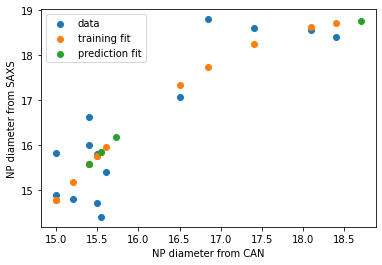

In [182]:
# Convert columns to numeric
df_startsus['NP diameter from CAN\n [nm]'] = pd.to_numeric(df_startsus['NP diameter from CAN\n [nm]'], errors='coerce')
df_startsus['NP mean \ndiameter from SAXS [nm]'] = pd.to_numeric(df_startsus['NP mean \ndiameter from SAXS [nm]'], errors='coerce')


# Find fit between NP diameter from CAN and SAXS to estimate missing values
npd_can = df_startsus['NP diameter from CAN\n [nm]'].to_numpy()
npd_saxs = df_startsus['NP mean \ndiameter from SAXS [nm]'].to_numpy()

npd_data = np.stack((npd_can, npd_saxs), axis=1)

## linear fit between npd_can and npd_saxs, where npd_saxs is not nan
npd_data_clean = npd_data[~np.isnan(npd_data).any(axis=1)]
npd_data_nans = npd_data[np.isnan(npd_data).any(axis=1)]
npd_canc = npd_data_clean[:,0]
npd_saxsc = npd_data_clean[:,1]


# fit
fit = np.polyfit(npd_canc, npd_saxsc, 2)
fit_fn = np.poly1d(fit)

# plot
plt.figure()
plt.scatter(npd_canc, npd_saxsc, label='data')
plt.scatter(npd_canc, fit_fn(npd_canc), label='training fit')
plt.scatter(npd_data_nans[:, 0], fit_fn(npd_data_nans[:, 0]), label='prediction fit')
plt.xlabel('NP diameter from CAN')
plt.ylabel('NP diameter from SAXS')
plt.legend()
plt.show()

df['NP diameter from SAXS'] = pd.to_numeric(df['NP diameter from SAXS'], errors='coerce')
df['NP diameter from CAN'] = pd.to_numeric(df['NP diameter from CAN'], errors='coerce')

## Add NP diameter from SAXS to df
## Check if value in saxs is nan, if so, replace with value from fit, if value in saxs is not nan, keep value
df['NP diameter from SAXS'] = np.where(df['NP diameter from SAXS'].isnull(), fit_fn(df['NP diameter from CAN']), df['NP diameter from SAXS'])

In [183]:
import pandas as pd
import numpy as np

# Assuming `df` is your DataFrame and `str2num` contains mappings for categorical features

# Handle other replacements using replace_function as before
replace_function(df, 'Pressure during\nPressing [MPa]', term='no pressing', new_term=0.1, in_place=True)
replace_function(df, 'Temperature during pressing [°C]', term='no pressing', new_term=room_temp, in_place=True)
replace_function(df, 'Heat \nTreatment [°C]', term='no HT', new_term=room_temp, in_place=True)
replace_function(df, 'Heat \nTreatment Time [h]', term='no HT', new_term=0, in_place=True)

# One-hot encode 'Heat \nTreatment atmosphere', 'Solvent', 'SA Method', and 'Ligand'
df = pd.get_dummies(df, columns=['Heat \nTreatment atmosphere', 'Solvent', 'SA Method', 'Ligand'])

# Apply other categorical mappings as necessary
df, str2num = replace_categorical_var(df, 'Starting Suspension', str2num, add_new_col=True, ignore=['unknown', 'NaN'])

replace_function(df, 'SA Temperature\n [°C]', term='room', new_term=room_temp, in_place=True)
replace_function(df, 'Order acc. to SAXS', term='amourphous', new_term='amorphous', in_place=True)  # Fixing typo

# Mapping for 'Order acc. to SAXS'
mapping = {'amorphous': 0, 'very low': 1, 'low': 2, 'medium': 3, 'high': 4, 'very high': 5}
df, str2num = replace_categorical_var(df, 'Order acc. to SAXS', str2num, mapping=mapping, add_new_col=False, ignore=['not measured', 'unknown'])

print("Starting Suspensions")
print('-------------------')
for i in np.sort(list(set(df['Starting Suspension']))):
    print(i)

print("\nFeatures")
print("---------")
for i in df.keys():
    print(i, ',')


Starting Suspensions
-------------------
CAN-1
CAN-11
CAN-12
CAN-2
CAN-3
CAN-4
CAN-5
CAN-6
CAN-8
CAN-9
MK-LODPA-1-6WS
UNIHAMB-1
UNIHAMB-2
UNIHAMB-3
UNIHAMB-5 (UDPA)
UNIHAMB-6 (OPA)
unknown

Features
---------
Sample Name ,
Starting Suspension ,
Pressure during
Pressing [MPa] ,
Temperature during pressing [°C] ,
Heat 
Treatment [°C] ,
Heat 
Treatment Time [h] ,
SA Temperature
 [°C] ,
Concentration
 [g/L] ,
SEM folder name ,
Order acc. to SAXS ,
NP mean 
radius [nm] ,
NP mean 
diameter [nm] ,
domain 
size [nm] ,
crystal lattice
parameter a ,
Interparticle 
Distance [nm] ,
Nearest neighbour distance [nm] ,
Organic Content
 (TGA) [w%] ,
SAXs Scan Date  ,
Tip  ,
Indentation
 depth [nm] ,
Elastic 
Modulus [Gpa] ,
SD ,
Hardness [Gpa] ,
SD.1 ,
Date of Nanoidentation ,
additional comments ,
NP diameter from CAN ,
NP diameter from SAXS ,
SD Particle Radius ,
Heat 
Treatment atmosphere_air ,
Heat 
Treatment atmosphere_air + nitrogen ,
Heat 
Treatment atmosphere_nitrogen ,
Heat 
Treatment atmosphe

/tmp/ipykernel_359659/3810347011.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  return x[column].replace(term, new_term, inplace=in_place)
/tmp/ipykernel_359659/3810347011.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [184]:
df['SD Particle Radius'] = df['Starting Suspension'].map(dict(zip(df_startsus['Sample Name'], df_startsus['SD particle radius  [nm]'])))
# Mapping from df_startsus to df using Starting Suspension as a common identifier
df['Organic Content by CAN [w%]'] = df['Starting Suspension'].map(dict(zip(df_startsus['Sample Name'], df_startsus['Organic Content by CAN [w%]'])))
df['SD Particle Radius'] = df['Starting Suspension'].map(dict(zip(df_startsus['Sample Name'], df_startsus['SD particle radius  [nm]'])))
df['NP Radius from SAXS'] = df['Starting Suspension'].map(dict(zip(df_startsus['Sample Name'], df_startsus['NP  \nradius from SAXS (mode) [nm]'])))
print(df[['Starting Suspension', 'Organic Content by CAN [w%]', 'SD Particle Radius', 'NP Radius from SAXS']].head())


  Starting Suspension  Organic Content by CAN [w%]  SD Particle Radius  \
0               CAN-1                         11.0             0.10644   
1               CAN-1                         11.0             0.10644   
2               CAN-1                         11.0             0.10644   
3               CAN-1                         11.0             0.10644   
4               CAN-1                         11.0             0.10644   

   NP Radius from SAXS  
0                  9.3  
1                  9.3  
2                  9.3  
3                  9.3  
4                  9.3  


In [185]:
print(df[['Starting Suspension', 'Organic Content by CAN [w%]', 'SD Particle Radius', 'NP Radius from SAXS']].iloc[10:15])


   Starting Suspension  Organic Content by CAN [w%]  SD Particle Radius  \
10               CAN-1                         11.0             0.10644   
11               CAN-1                         11.0             0.10644   
12               CAN-1                         11.0             0.10644   
13               CAN-1                         11.0             0.10644   
14               CAN-1                         11.0             0.10644   

    NP Radius from SAXS  
10                  9.3  
11                  9.3  
12                  9.3  
13                  9.3  
14                  9.3  


In [186]:
print(df[['Organic Content by CAN [w%]', 'SD Particle Radius', 'NP Radius from SAXS']].isnull().sum())
print(df.shape)


Organic Content by CAN [w%]    46
SD Particle Radius              3
NP Radius from SAXS            24
dtype: int64
(298, 60)


In [187]:

df.dropna(subset=['Organic Content by CAN [w%]', 'SD Particle Radius', 'NP Radius from SAXS'], inplace=True)
# Check again for missing values if filled
print(df[['Organic Content by CAN [w%]', 'SD Particle Radius', 'NP Radius from SAXS']].isnull().sum())

# Or check the new shape if rows were dropped
print(df.shape)


Organic Content by CAN [w%]    0
SD Particle Radius             0
NP Radius from SAXS            0
dtype: int64
(231, 60)


In [188]:
# Drop rows with NaN in the specified columns
df.dropna(subset=['Organic Content by CAN [w%]', 'SD Particle Radius', 'NP Radius from SAXS'], inplace=True)

# Check for remaining missing values in the specified columns
print(df[['Organic Content by CAN [w%]', 'SD Particle Radius', 'NP Radius from SAXS']].isnull().sum())

# Check the new shape of the main DataFrame after dropping rows
print("Remaining rows in the main DataFrame (df):", df.shape[0])

# Print the Sample Names available after dropping rows with NaN
print("Sample Names available after dropping rows with NaN in the main DataFrame:")
print(df['Sample Name'].unique())

# Check the new shape of the starting suspensions DataFrame
print("Remaining rows in the starting suspensions DataFrame (df_startsus):", df_startsus.shape[0])

# Additionally, check for missing values in the relevant columns of df_startsus
print(df_startsus[['Organic Content by CAN [w%]', 'SD particle radius  [nm]', 'NP  \nradius from SAXS (mode) [nm]']].isnull().sum())

# Print the Sample Names in the starting suspensions DataFrame
print("Sample Names in the starting suspensions DataFrame:")
print(df_startsus['Sample Name'].unique())


Organic Content by CAN [w%]    0
SD Particle Radius             0
NP Radius from SAXS            0
dtype: int64
Remaining rows in the main DataFrame (df): 231
Sample Names available after dropping rows with NaN in the main DataFrame:
['Fe3O4-OA_04' 'Fe3O4-OA-04_350' 'Fe3O4-OA-10' 'Fe3O4-OA-10-D15_325'
 'Fe3O4-OA-23-325' 'Fe3O4-OA-23-D10' 'Fe3O4-OA-24' 'Fe3O4-OA-24-325'
 'Fe3O4-OA-24-D10' 'Fe3O4-OA-25-D10' 'Fe3O4-OA-26' 'Fe3O4-OA-26-325'
 'Fe3O4-OA-26-D10' 'Fe3O4-OA-27' 'Fe3O4-OA-27-325' 'Fe3O4-OA-27-D10'
 'Fe3O4-OA-28' 'Fe3O4-OA-28_250' 'Fe3O4-OA-28_300' 'Fe3O4-OA-28_350'
 'Fe3O4-OA-28_400' 'Fe3O4-OA-29-325' 'Fe3O4-OA-29-D10' 'Fe3O4-OA-31-325'
 'Fe3O4-OA-31-D10' 'Fe3O4-OA-32' 'Fe3O4-OA-32-325_2000nm'
 'Fe3O4-OA-32-325_200nm' 'Fe3O4-OA-32-D14_300' 'Fe3O4-OA-32-D14_325'
 'Fe3O4-OA-32-D14_350' 'Fe3O4-OA-33' 'Fe3O4-OA-33_250' 'Fe3O4-OA-33_350'
 'Fe3O4-OA-34' 'Fe3O4-OA-34_250' 'Fe3O4-OA-34_350' 'Fe3O4-OA-35'
 'Fe3O4-OA-35_250' 'Fe3O4-OA-37' 'Fe3O4-OA-37-325' 'Fe3O4-OA-38'
 'Fe3O4-OA-40' 'Fe

In [189]:
# Step 1: Check the initial number of unique Sample Name values
initial_sample_names = df_startsus['Sample Name'].unique()
print("Initial unique Sample Name values:", len(initial_sample_names))
print("Initial Sample Names:", initial_sample_names)

# Step 2: Drop rows with NaN values in the specified columns
df_startsus.dropna(subset=['Organic Content by CAN [w%]', 'SD particle radius  [nm]', 'NP  \nradius from SAXS (mode) [nm]'], inplace=True)

# Step 3: Check the number of unique Sample Name values after dropping rows with NaN values
remaining_sample_names = df_startsus['Sample Name'].unique()
print("Remaining unique Sample Name values:", len(remaining_sample_names))
print("Remaining Sample Names:", remaining_sample_names)


Initial unique Sample Name values: 19
Initial Sample Names: ['CAN-1' 'CAN-10' 'CAN-11' 'CAN-12' 'CAN-2' 'CAN-3' 'CAN-4' 'CAN-5'
 'CAN-6' 'CAN-7' 'CAN-8' 'CAN-9' 'MK-LODPA-1-6WS' 'UNIHAMB-1' 'UNIHAMB-2'
 'UNIHAMB-3' 'UNIHAMB-4' 'UNIHAMB-5 (UDPA)' 'UNIHAMB-6 (OPA)']
Remaining unique Sample Name values: 13
Remaining Sample Names: ['CAN-1' 'CAN-10' 'CAN-11' 'CAN-2' 'CAN-3' 'CAN-4' 'CAN-5' 'CAN-6' 'CAN-7'
 'CAN-8' 'CAN-9' 'MK-LODPA-1-6WS' 'UNIHAMB-2']


In [190]:
ignore_unknown_rows = [
    'Pressure during\nPressing [MPa]',
    'Temperature during pressing [°C]',
    'Heat \nTreatment [°C]',
    'Heat \nTreatment Time [h]',
    'SA Temperature\n [°C]',
    'Concentration\n [g/L]'
]

# Loop through columns that may contain 'unknown' and filter them out
for unknown_col in ignore_unknown_rows:
    df = df.loc[df[unknown_col] != 'unknown']
    df = df.loc[~df[unknown_col].isnull()]

# Filter by known SAXS order, removing entries labeled as 'unknown' or 'not measured'
df_ord = df.loc[df['Order acc. to SAXS'] != 'unknown']
df_ord = df_ord.loc[df_ord['Order acc. to SAXS'] != 'not measured']

# Output the remaining rows and a unique list from a column for verification
print("Remaining rows: ", df_ord.shape[0])
for i in np.sort(list(set(df_ord['Starting Suspension']))):
    print(i)

Remaining rows:  105
CAN-1
CAN-2
CAN-3
MK-LODPA-1-6WS
UNIHAMB-2


In [191]:
###############
print('shape, known features:', df.shape)
print('shape, known order:', df_ord.shape)
df.to_excel(datafile+'Data Collection for ML_NEW_cleaned.xlsx')


shape, known features: (179, 60)
shape, known order: (105, 60)


In [192]:
one_hot_encoded_columns = [
    col for col in df_ord.columns if col.startswith('Heat \nTreatment atmosphere_') or col.startswith('Solvent_') or col.startswith('SA Method_') or col.startswith('Ligand_')
    if not col.endswith('_unknown')
]

# Updating the inputs list
inputs = [
    'Organic Content by CAN [w%]', 'SD Particle Radius', 'NP Radius from SAXS', 
    'Pressure during\nPressing [MPa]', 'Temperature during pressing [°C]', 
    'Heat \nTreatment [°C]', 'Heat \nTreatment Time [h]',
    'SA Temperature\n [°C]', 'Concentration\n [g/L]'
] + one_hot_encoded_columns

outputs = ['Order acc. to SAXS']

# Saving the filtered DataFrame to Excel
df_ord[inputs + outputs].to_excel(datafile + 'Data Collection for ML_NEW_cleaned_inputs_outputs.xlsx')

# Converting inputs to numpy arrays and handling any potential numeric conversion issues
df_input = np.asarray(df_ord[inputs], dtype=float)
df_output = np.ravel(np.asarray(df_ord[outputs], dtype=float))

# Applying numeric conversion and handling NaN values in the DataFrame
df[inputs] = df[inputs].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=inputs, inplace=True)

In [193]:
#########updates 
df = df[df['Order acc. to SAXS'] != 'not measured']


df['Order acc. to SAXS'] = pd.to_numeric(df['Order acc. to SAXS'], errors='coerce')  
df.dropna(subset=['Order acc. to SAXS'], inplace=True)  
df_input = np.asarray(df[inputs], dtype=float)
df_output = np.ravel(np.asarray(df[outputs], dtype=float))


In [194]:
inputs = [
    'Organic Content by CAN [w%]', 'SD Particle Radius', 'NP Radius from SAXS', 
    'Pressure during\nPressing [MPa]', 'Temperature during pressing [°C]', 
    'Heat \nTreatment [°C]', 'Heat \nTreatment Time [h]', 
    'SA Temperature\n [°C]', 'Concentration\n [g/L]'
] + one_hot_encoded_columns  # Including 'SA Method', 'Ligand' and other one-hot encoded columns

outputs = ['Order acc. to SAXS']

# Combine inputs and output into a single DataFrame for display
df_combined = df[inputs + outputs]

# Print the DataFrame in a clean, formatted way
print("Inputs and Output Data:")
print("-----------------------")
print(df_combined.to_string(index=False))

Inputs and Output Data:
-----------------------
 Organic Content by CAN [w%]  SD Particle Radius  NP Radius from SAXS  Pressure during\nPressing [MPa]  Temperature during pressing [°C]  Heat \nTreatment [°C]  Heat \nTreatment Time [h]  SA Temperature\n [°C]  Concentration\n [g/L]  Heat \nTreatment atmosphere_air  Heat \nTreatment atmosphere_air + nitrogen  Heat \nTreatment atmosphere_nitrogen  Heat \nTreatment atmosphere_no HT  Solvent_CHCl3  Solvent_Toluene  Solvent_Toluene + Acetone  Solvent_Toluene + EtOH  Solvent_Toluene + EtOh  SA Method_Evaporated in 3 days.  SA Method_Evaporated in 6 days.  SA Method_Evaporated in 7 days  SA Method_Evaporated in 8 days  SA Method_Evaporated in 9 days  SA Method_destabilization  SA Method_evaporation  SA Method_fast evaporation in 20 min  SA Method_fast evaporation in 2min 20 sec  SA Method_interrupted destabilization  SA Method_repeated destabilization  Ligand_OA  Ligand_ODPA  Ligand_OPA  Ligand_OPh  Ligand_UDPA  Order acc. to SAXS
             

In [195]:
# Identify one-hot encoded columns for 'Heat Treatment Atmosphere' and 'Solvent'
one_hot_encoded_columns = [
    col for col in df_ord.columns if col.startswith('Heat \nTreatment atmosphere_') or col.startswith('Solvent_') or col.startswith('SA Method_') or col.startswith('Ligand_')
    if not col.endswith('_unknown')
]
# Display the one-hot encoded columns
print("One-hot encoded columns")
print(one_hot_encoded_columns)


One-hot encoded columns
['Heat \nTreatment atmosphere_air', 'Heat \nTreatment atmosphere_air + nitrogen', 'Heat \nTreatment atmosphere_nitrogen', 'Heat \nTreatment atmosphere_no HT', 'Solvent_CHCl3', 'Solvent_Toluene', 'Solvent_Toluene + Acetone', 'Solvent_Toluene + EtOH', 'Solvent_Toluene + EtOh', 'SA Method_Evaporated in 3 days.', 'SA Method_Evaporated in 6 days.', 'SA Method_Evaporated in 7 days', 'SA Method_Evaporated in 8 days', 'SA Method_Evaporated in 9 days', 'SA Method_destabilization', 'SA Method_evaporation', 'SA Method_fast evaporation in 20 min', 'SA Method_fast evaporation in 2min 20 sec', 'SA Method_interrupted destabilization', 'SA Method_repeated destabilization', 'Ligand_OA', 'Ligand_ODPA', 'Ligand_OPA', 'Ligand_OPh', 'Ligand_UDPA']


In [196]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from scipy.stats import uniform

# Assuming df_filtered is your cleaned DataFrame
df_filtered = df_ord  # Ensure df_ord is defined and contains all necessary columns

# Update one-hot encoded columns based on our latest discussion
one_hot_encoded_columns = [
    'Heat \nTreatment atmosphere_air',
    'Heat \nTreatment atmosphere_air + nitrogen',
    'Heat \nTreatment atmosphere_nitrogen',
    'Heat \nTreatment atmosphere_no HT',
    'Solvent_CHCl3', 
    'Solvent_Toluene', 
    'Solvent_Toluene + Acetone',
    'Solvent_Toluene + EtOH', 
    'Solvent_Toluene + EtOh', 
    'SA Method_Evaporated in 3 days.', 
    'SA Method_Evaporated in 6 days.', 
    'SA Method_Evaporated in 7 days', 
    'SA Method_Evaporated in 8 days', 
    'SA Method_Evaporated in 9 days', 
    'SA Method_destabilization', 
    'SA Method_evaporation', 
    'SA Method_fast evaporation in 20 min', 
    'SA Method_fast evaporation in 2min 20 sec', 
    'SA Method_interrupted destabilization', 
    'SA Method_repeated destabilization', 
    'Ligand_OA', 
    'Ligand_ODPA', 
    'Ligand_OPA', 
    'Ligand_OPh', 
    'Ligand_UDPA'
]

# Ensure the correct column names
input_columns = [
    'Organic Content by CAN [w%]',
    'NP Radius from SAXS',
    'Concentration\n [g/L]',
    'Pressure during\nPressing [MPa]',
    'Temperature during pressing [°C]',
    'Heat \nTreatment [°C]',
    'Heat \nTreatment Time [h]',
    'SA Temperature\n [°C]',
] + one_hot_encoded_columns  # Add your one-hot encoded columns here for Heat Treatment Atmosphere and Solvent

output_column = 'Order acc. to SAXS'

# Split the data into training and testing sets
X = df_filtered[input_columns].values
y = df_filtered[output_column].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features based on the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Apply the same transformation to the test set

# Define the model and hyperparameter space for randomized search
mlp = MLPRegressor(random_state=42)
param_dist = {
    'hidden_layer_sizes': [(100, 100), (150, 150), (200, 200)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.05),
    'learning_rate_init': uniform(0.001, 0.01)
}

# Perform 5-fold cross-validation with randomized search
kf = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=20, cv=kf, n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Best model after hyperparameter tuning
best_mlp = random_search.best_estimator_

# Train the best model on the entire training dataset
best_mlp.fit(X_train_scaled, y_train)

# Predict using the best model on the test set
y_pred_test = best_mlp.predict(X_test_scaled)

# Calculate the score using the formula on the test set
scores_test = 1 - np.abs(y_pred_test - y_test) / 5

# Calculate the mean score on the test set
mean_score_test = np.mean(scores_test)

print(f"Mean score of the model on the test set based on the formula 1 - abs(pred - true) / 5: {mean_score_test:.4f}")

/home/amin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/amin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/amin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/amin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/amin/.local/lib/python3.10/site-packages/sklearn/n

Mean score of the model on the test set based on the formula 1 - abs(pred - true) / 5: 0.9038


/home/amin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Optimal PC1: 4.042400191621563
Optimal PC2: 1.23170798995887
Predicted order at optimal point: 4.484237844746001
Feature values corresponding to maximum predicted order using SGD:
   Organic Content by CAN [w%]  NP Radius from SAXS  Concentration\n [g/L]  \
0                    10.416224             8.223258             142.034688   

   Pressure during\nPressing [MPa]  Temperature during pressing [°C]  \
0                         1.225817                         22.877888   

   Heat \nTreatment [°C]  Heat \nTreatment Time [h]  SA Temperature\n [°C]  \
0              -3.376045                    0.03395               19.57054   

   Heat \nTreatment atmosphere_air  \
0                     1.753112e-18   

   Heat \nTreatment atmosphere_air + nitrogen  ...  SA Method_evaporation  \
0                               -8.346378e-21  ...               -0.17254   

   SA Method_fast evaporation in 20 min  \
0                                   0.0   

   SA Method_fast evaporation in 2min 20 s

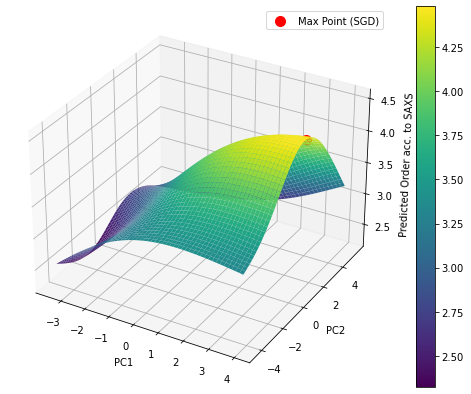

In [202]:



import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# 1. Prepare the PCA components using the training data
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_train_scaled)

# 2. Define the objective function to maximize predicted order
def objective_function(pca_values):
    # Map PCA values back to original input space
    original_space = pca.inverse_transform(pca_values.reshape(1, -1))
    
    # Predict order using the neural network
    predicted_order = best_mlp.predict(original_space)
    
    # Return negative order because we are maximizing, 
    return -predicted_order[0]

# 3. Initial guess for PC1 and PC2 (starting near the mean of the PCA components)
initial_pc1 = pca_components[:, 0].mean()
initial_pc2 = pca_components[:, 1].mean()
initial_guess = np.array([initial_pc1, initial_pc2])

# 4. Use gradient-based optimization (SGD) to find the maximum
# Here we use 'BFGS', a gradient-based algorithm available in `scipy.optimize.minimize`.
result = minimize(objective_function, initial_guess, method='BFGS')

# 5. Extract the optimal PC1 and PC2 values from the result
optimal_pc1, optimal_pc2 = result.x

# 6. Predict the order corresponding to the optimal PCA point
optimal_pca_point = np.array([optimal_pc1, optimal_pc2]).reshape(1, -1)
max_original_space_point = pca.inverse_transform(optimal_pca_point)
max_predicted_order = -result.fun  # Remember, we minimized the negative predicted order

# Print PC1, PC2, and their respective predicted order value
print(f"Optimal PC1: {optimal_pc1}")
print(f"Optimal PC2: {optimal_pc2}")
print(f"Predicted order at optimal point: {max_predicted_order}")

# 7. Map the optimal PCA point back to the original feature space
max_original_space_unscaled = scaler.inverse_transform(max_original_space_point)

# Display the original feature values corresponding to the maximum predicted order
max_original_space_df = pd.DataFrame(max_original_space_unscaled, columns=input_columns)
print("Feature values corresponding to maximum predicted order using SGD:")
print(max_original_space_df)

# 8. Generate the grid for visualization (optional step to plot the surface)
pc1_min, pc1_max = pca_components[:, 0].min(), pca_components[:, 0].max()
pc2_min, pc2_max = pca_components[:, 1].min(), pca_components[:, 1].max()

pc1_grid = np.linspace(pc1_min, pc1_max, 1500)
pc2_grid = np.linspace(pc2_min, pc2_max, 1500)
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

grid_points = np.vstack([pc1_grid.ravel(), pc2_grid.ravel()]).T
original_space_grid = pca.inverse_transform(grid_points)

# Predict order values for the grid points
predicted_order_grid = best_mlp.predict(original_space_grid)

# Ensure the predicted_order_grid has the correct shape for plotting
predicted_order_grid = predicted_order_grid.reshape(pc1_grid.shape)

# 9. Plot the surface and highlight the maximum point
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
surf = ax.plot_surface(pc1_grid, pc2_grid, predicted_order_grid, cmap='viridis')

# Adding color bar for reference
plt.colorbar(surf)

# Adding labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Predicted Order acc. to SAXS')

# Highlight the maximum point found by SGD
ax.scatter(optimal_pc1, optimal_pc2, max_predicted_order, color='red', s=100, label="Max Point (SGD)")
ax.legend()

# Display the plot
plt.show()




In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# 1. Prepare the PCA components using the training data
X_train_scaled = scaler.transform(X_train)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_train_scaled)

# 2. Generate a grid of values in the PCA space (PC1 and PC2)
pc1_min, pc1_max = pca_components[:, 0].min(), pca_components[:, 0].max()
pc2_min, pc2_max = pca_components[:, 1].min(), pca_components[:, 1].max()

pc1_grid = np.linspace(pc1_min, pc1_max, 1000)
pc2_grid = np.linspace(pc2_min, pc2_max, 1000)
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# 3. Map the grid points back to the original input space
grid_points = np.vstack([pc1_grid.ravel(), pc2_grid.ravel()]).T
original_space_grid = pca.inverse_transform(grid_points)

# 4. Predict the order values using the trained neural network
predicted_order_grid = best_mlp.predict(original_space_grid)
predicted_order_grid = predicted_order_grid.reshape(pc1_grid.shape)

# 5. Find the maximum predicted order and the corresponding PC1 and PC2 values
max_index = np.unravel_index(np.argmax(predicted_order_grid, axis=None), predicted_order_grid.shape)
max_pc1 = pc1_grid[max_index]
max_pc2 = pc2_grid[max_index]
max_predicted_order = predicted_order_grid[max_index]

print(f"Maximum predicted order in PCA space: {max_predicted_order}")
print(f"PC1 value at maximum: {max_pc1}")
print(f"PC2 value at maximum: {max_pc2}")

# 6. Map the maximum point in PCA space back to the original feature space
max_pca_point = np.array([max_pc1, max_pc2]).reshape(1, -1)
max_original_space_point = pca.inverse_transform(max_pca_point)
max_original_space_unscaled = scaler.inverse_transform(max_original_space_point)

# 7. Apply numeric constraints on the max point
max_original_space_unscaled = max_original_space_unscaled[0]

# Define constraints
numeric_constraints = {
    'Heat \nTreatment Time [h]': 0,
    'Heat \nTreatment [°C]': 20,
    'SA Temperature\n [°C]': 20,
    'Pressure during\nPressing [MPa]': 0.1
}

# Apply numeric constraints
max_original_space_unscaled[input_columns.index('Heat \nTreatment Time [h]')] = max(
    max_original_space_unscaled[input_columns.index('Heat \nTreatment Time [h]')], numeric_constraints['Heat \nTreatment Time [h]']
)
max_original_space_unscaled[input_columns.index('Heat \nTreatment [°C]')] = max(
    max_original_space_unscaled[input_columns.index('Heat \nTreatment [°C]')], numeric_constraints['Heat \nTreatment [°C]']
)
max_original_space_unscaled[input_columns.index('SA Temperature\n [°C]')] = max(
    max_original_space_unscaled[input_columns.index('SA Temperature\n [°C]')], numeric_constraints['SA Temperature\n [°C]']
)
max_original_space_unscaled[input_columns.index('Pressure during\nPressing [MPa]')] = max(
    max_original_space_unscaled[input_columns.index('Pressure during\nPressing [MPa]')], numeric_constraints['Pressure during\nPressing [MPa]']
)

# 8. Apply one-hot encoding constraints
groups = {
    'Heat \nTreatment atmosphere': [
        'Heat \nTreatment atmosphere_air', 
        'Heat \nTreatment atmosphere_air + nitrogen', 
        'Heat \nTreatment atmosphere_nitrogen', 
        'Heat \nTreatment atmosphere_no HT'
    ],
    'Solvent': [
        'Solvent_CHCl3', 
        'Solvent_Toluene', 
        'Solvent_Toluene + Acetone', 
        'Solvent_Toluene + EtOH', 
        'Solvent_Toluene + EtOh'
    ],
    'SA Method': [
        'SA Method_Evaporated in 3 days.', 
        'SA Method_Evaporated in 6 days.', 
        'SA Method_Evaporated in 7 days', 
        'SA Method_Evaporated in 8 days', 
        'SA Method_Evaporated in 9 days', 
        'SA Method_destabilization', 
        'SA Method_evaporation', 
        'SA Method_fast evaporation in 20 min', 
        'SA Method_fast evaporation in 2min 20 sec', 
        'SA Method_interrupted destabilization', 
        'SA Method_repeated destabilization'
    ],
    'Ligand': [
        'Ligand_OA', 
        'Ligand_ODPA', 
        'Ligand_OPA', 
        'Ligand_OPh', 
        'Ligand_UDPA'
    ]
}

# Enforce one-hot encoding constraints for categorical groups
for group_name, group_columns in groups.items():
    group_indices = [input_columns.index(col) for col in group_columns]
    group_values = max_original_space_unscaled[group_indices]
    max_index = np.argmax(group_values)
    # Set the max category to 1 and the others to 0
    for i in range(len(group_indices)):
        max_original_space_unscaled[group_indices[i]] = 1 if i == max_index else 0

# Apply the constraint: If 'Heat \nTreatment atmosphere' is 'no HT', then set 'Heat \nTreatment Time [h]' to 0
heat_treatment_group = groups['Heat \nTreatment atmosphere']
no_ht_index = input_columns.index('Heat \nTreatment atmosphere_no HT')
if max_original_space_unscaled[no_ht_index] == 1:
    max_original_space_unscaled[input_columns.index('Heat \nTreatment Time [h]')] = 0

# 9. Predict using the neural network with the applied constraints
max_original_space_scaled = scaler.transform([max_original_space_unscaled])
neural_network_prediction = best_mlp.predict(max_original_space_scaled)[0]

# 10. Display the result
max_original_space_df = pd.DataFrame([max_original_space_unscaled], columns=input_columns)
max_original_space_df['Neural Network Prediction'] = neural_network_prediction

print("Feature values after applying constraints and their prediction:")
print(max_original_space_df.to_string(index=False))


Maximum predicted order in PCA space: 4.484206942529179
PC1 value at maximum: 4.007560231085178
PC2 value at maximum: 1.2222431464654457
Feature values after applying constraints and their prediction:
 Organic Content by CAN [w%]  NP Radius from SAXS  Concentration\n [g/L]  Pressure during\nPressing [MPa]  Temperature during pressing [°C]  Heat \nTreatment [°C]  Heat \nTreatment Time [h]  SA Temperature\n [°C]  Heat \nTreatment atmosphere_air  Heat \nTreatment atmosphere_air + nitrogen  Heat \nTreatment atmosphere_nitrogen  Heat \nTreatment atmosphere_no HT  Solvent_CHCl3  Solvent_Toluene  Solvent_Toluene + Acetone  Solvent_Toluene + EtOH  Solvent_Toluene + EtOh  SA Method_Evaporated in 3 days.  SA Method_Evaporated in 6 days.  SA Method_Evaporated in 7 days  SA Method_Evaporated in 8 days  SA Method_Evaporated in 9 days  SA Method_destabilization  SA Method_evaporation  SA Method_fast evaporation in 20 min  SA Method_fast evaporation in 2min 20 sec  SA Method_interrupted destabilizati

In [218]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Prepare the PCA components using the training data
X_train_scaled = scaler.transform(X_train)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_train_scaled)

# 2. Generate a grid of values in the PCA space (PC1 and PC2)
pc1_min, pc1_max = pca_components[:, 0].min(), pca_components[:, 0].max()
pc2_min, pc2_max = pca_components[:, 1].min(), pca_components[:, 1].max()

pc1_grid = np.linspace(pc1_min, pc1_max, 200)
pc2_grid = np.linspace(pc2_min, pc2_max, 200)
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# 3. Map the grid points back to the original input space
grid_points = np.vstack([pc1_grid.ravel(), pc2_grid.ravel()]).T
original_space_grid = pca.inverse_transform(grid_points)

# 4. Predict the order values using the trained neural network
predicted_order_grid = best_mlp.predict(original_space_grid)

# 5. Filter the grid points where the predicted order >= 4.3
valid_region_mask = predicted_order_grid >= 4.35

# 6. Apply the mask to the flattened original space grid
valid_original_space_points = original_space_grid[valid_region_mask]

# 7. Reverse the standard scaling for continuous features
unscaled_original_space_grid = scaler.inverse_transform(valid_original_space_points)

# 8. Apply the logical constraints for continuous features
valid_mask = (
    (unscaled_original_space_grid[:, input_columns.index('Heat \nTreatment Time [h]')] > 0) &
    (unscaled_original_space_grid[:, input_columns.index('Heat \nTreatment [°C]')] > 20) &
    (unscaled_original_space_grid[:, input_columns.index('SA Temperature\n [°C]')] > 20) &
    (unscaled_original_space_grid[:, input_columns.index('Pressure during\nPressing [MPa]')] > 0.1)
)
filtered_original_space_grid = unscaled_original_space_grid[valid_mask]

# 9. Enforce one-hot encoding constraints for categorical variables
groups = {
    'Heat \nTreatment atmosphere': ['Heat \nTreatment atmosphere_air', 'Heat \nTreatment atmosphere_air + nitrogen', 'Heat \nTreatment atmosphere_nitrogen', 'Heat \nTreatment atmosphere_no HT'],
    'Solvent': ['Solvent_CHCl3', 'Solvent_Toluene', 'Solvent_Toluene + Acetone', 'Solvent_Toluene + EtOH', 'Solvent_Toluene + EtOh'],
    'SA Method': ['SA Method_Evaporated in 3 days.', 'SA Method_Evaporated in 6 days.', 'SA Method_Evaporated in 7 days', 'SA Method_Evaporated in 8 days', 'SA Method_Evaporated in 9 days', 'SA Method_destabilization', 'SA Method_evaporation', 'SA Method_fast evaporation in 20 min', 'SA Method_fast evaporation in 2min 20 sec', 'SA Method_interrupted destabilization', 'SA Method_repeated destabilization'],
    'Ligand': ['Ligand_OA', 'Ligand_ODPA', 'Ligand_OPA', 'Ligand_OPh', 'Ligand_UDPA']
}

# Enforce one-hot encoding for categorical variables
for group_name, group_columns in groups.items():
    group_indices = [input_columns.index(col) for col in group_columns]
    for i in range(filtered_original_space_grid.shape[0]):
        group_values = filtered_original_space_grid[i, group_indices]
        max_index = np.argmax(group_values)
        filtered_original_space_grid[i, group_indices] = 0  
        filtered_original_space_grid[i, group_indices[max_index]] = 1

# Apply the new logical constraint: if 'Heat \nTreatment atmosphere_no HT' is active, set 'Heat \nTreatment Time [h]' to 0
no_ht_index = input_columns.index('Heat \nTreatment atmosphere_no HT')
heat_treatment_time_index = input_columns.index('Heat \nTreatment Time [h]')

# Loop over each row and check if 'no HT' is active; if so, set 'Heat \nTreatment Time [h]' to 0
for i in range(filtered_original_space_grid.shape[0]):
    if filtered_original_space_grid[i, no_ht_index] == 1:
        filtered_original_space_grid[i, heat_treatment_time_index] = 0

# 11. Predict the order values for the filtered points
filtered_scaled_grid = scaler.transform(filtered_original_space_grid)
predicted_order_filtered = best_mlp.predict(filtered_scaled_grid)

# 12. Prepare the valid data table with predictions
valid_data_with_predictions = pd.DataFrame(filtered_original_space_grid, columns=input_columns)
valid_data_with_predictions['Predicted Order acc. to SAXS'] = predicted_order_filtered

# Display the valid results
print("Valid input combinations with Predicted Order acc. to SAXS >= 4.3:")
print(valid_data_with_predictions.to_string(index=False))


Valid input combinations with Predicted Order acc. to SAXS >= 4.3:
 Organic Content by CAN [w%]  NP Radius from SAXS  Concentration\n [g/L]  Pressure during\nPressing [MPa]  Temperature during pressing [°C]  Heat \nTreatment [°C]  Heat \nTreatment Time [h]  SA Temperature\n [°C]  Heat \nTreatment atmosphere_air  Heat \nTreatment atmosphere_air + nitrogen  Heat \nTreatment atmosphere_nitrogen  Heat \nTreatment atmosphere_no HT  Solvent_CHCl3  Solvent_Toluene  Solvent_Toluene + Acetone  Solvent_Toluene + EtOH  Solvent_Toluene + EtOh  SA Method_Evaporated in 3 days.  SA Method_Evaporated in 6 days.  SA Method_Evaporated in 7 days  SA Method_Evaporated in 8 days  SA Method_Evaporated in 9 days  SA Method_destabilization  SA Method_evaporation  SA Method_fast evaporation in 20 min  SA Method_fast evaporation in 2min 20 sec  SA Method_interrupted destabilization  SA Method_repeated destabilization  Ligand_OA  Ligand_ODPA  Ligand_OPA  Ligand_OPh  Ligand_UDPA  Predicted Order acc. to SAXS
    

Fully display any row you want 

In [ ]:

# pd.set_option('display.max_rows', None)


# print(valid_data_with_predictions['Predicted Order acc. to SAXS'])
